In [1]:
import matplotlib.pyplot as plt
from mxnet import nd, autograd, init, gluon, context
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
import d2l

In [2]:
def get_dataloader(batch_size):
    transformer = transforms.Compose([
        transforms.ToTensor()
    ])
    train = gluon.data.vision.datasets.FashionMNIST(train=True)
    train = train.transform_first(transformer)
    train_iter = gluon.data.DataLoader(train, batch_size, shuffle=True, num_workers=4)
    test = gluon.data.vision.datasets.FashionMNIST(train=False)
    test = test.transform_first(transformer)
    test_iter = gluon.data.DataLoader(test, batch_size, shuffle=False, num_workers=4)
    return train_iter, test_iter

In [3]:
def show_images(X, nrows, ncols):
    _, axes = plt.subplots(nrows, ncols)
    axes = axes.flatten()
    for img, ax in zip(X, axes):
        ax.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    return axes

In [4]:
def eval_acc(net, data_iter, ctx):
    acc = 0
    size = 0
    for X, y in data_iter:
        X, y = X.as_in_context(ctx), y.as_in_context(ctx)
        result = net(X).softmax(axis=1)
        acc += (result.argmax(axis=1) == y.astype('float32')).sum().asscalar()
        size += len(y)
        
    return acc / size

In [5]:
def eval_loss(net, data_iter, loss, ctx):
    l = 0
    size = 0
    for X, y in data_iter:
        X, y = X.as_in_context(ctx), y.as_in_context(ctx)
        result = net(X)
        l += loss(result, y).sum().asscalar()
        size += len(y)
    return l / size

In [28]:
class BatchNorm(nn.Block):
    def __init__(self, num_features, **kwargs):
        super(BatchNorm, self).__init__(**kwargs)
        shape = (1, num_features, 1, 1)
        self.gamma = self.params.get('gamma', shape=shape, init=init.One())
        self.beta = self.params.get('beta', shape=shape, init=init.Zero())
        
        self.moving_avg = nd.zeros(shape)
        self.moving_var = nd.zeros(shape)
        
        self.eps = 1e-5
        self.momentum = 0.9
    def batch_norm(self, X):
        if not autograd.is_training():
            X_hat = (X - self.moving_avg) / (nd.sqrt(self.moving_var + self.eps))
        else:
            avg = X.mean(axis=(0, 2, 3), keepdims=True)
            var = ((X-avg)**2).mean(axis=(0, 2, 3), keepdims=True)
            self.moving_avg = self.momentum * self.moving_avg + (1.0-self.momentum)*avg
            self.moving_var = self.momentum * self.moving_var + (1.0-self.momentum)*var
            X_hat = (X - avg) / (nd.sqrt(var + self.eps))
        Y = self.gamma.data() * X_hat + self.beta.data()
        
        return Y
    def forward(self, x):
        self.moving_avg = self.moving_avg.as_in_context(X.context)
        self.moving_var = self.moving_var.as_in_context(X.context)
        
        Y = self.batch_norm(x)
        return Y

In [29]:
class LeNet(nn.Block):
    def __init__(self, **kwargs):
        super(LeNet, self).__init__(**kwargs)
        self.conv1 = nn.Conv2D(channels=6, kernel_size=5, padding=2)
        self.bn1 = BatchNorm(6)
        self.act1 = nn.Activation('sigmoid')
        self.dropout1 = nn.Dropout(0.2)
        self.pool1 = nn.AvgPool2D(pool_size=2)
        self.conv2 = nn.Conv2D(channels=16, kernel_size=5)
        self.bn2 = BatchNorm(16)
        self.act2 = nn.Activation('sigmoid')
        self.dropout2 = nn.Dropout(0.4)
        self.pool2 = nn.AvgPool2D(pool_size=2)
        self.dense1 = nn.Dense(120, activation='sigmoid')
        self.dense2 = nn.Dense(84, activation='sigmoid')
        self.dense3 = nn.Dense(10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.dropout1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.dropout2(x)
        x = self.pool2(x)
        x = self.dense1(x)
        x = self.dense2(x)
        out = self.dense3(x)
        return out

In [30]:
batch_size = 256
train_iter, test_iter = get_dataloader(batch_size)

ctx = context.gpu(0)

net = LeNet()
net.initialize(init=init.Xavier(), ctx=ctx)
testX = nd.random.normal(shape=(1, 1, 28, 28), ctx=ctx)
net(testX)


[[ 0.08774796  0.8490075   0.22524956 -0.48619097 -0.26120365  0.613436
  -0.2748482  -0.5002024   0.43346107 -0.6032125 ]]
<NDArray 1x10 @gpu(0)>

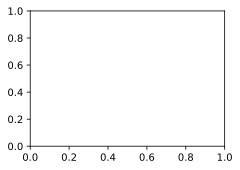

In [31]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':0.03})
epochs = 100
animator = d2l.Animator(xlabel='epoch', xlim=[0, epochs], legend=['loss', 'acc'])

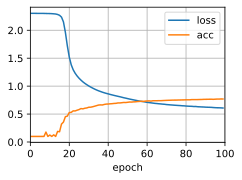

In [10]:
for epoch in range(epochs):
    for X, y in train_iter:
        X, y = X.as_in_context(ctx), y.as_in_context(ctx)
        with autograd.record():
            result = net(X)
            l = loss(result, y)
        l.backward()
        trainer.step(batch_size)
    epoch_loss = eval_loss(net, test_iter, loss, ctx)
    epoch_acc = eval_acc(net, test_iter, ctx)
    animator.add(epoch, (epoch_loss, epoch_acc))

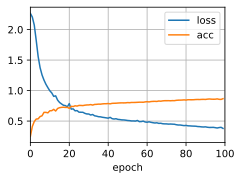

In [32]:
for epoch in range(epochs):
    for X, y in train_iter:
        X, y = X.as_in_context(ctx), y.as_in_context(ctx)
        with autograd.record():
            result = net(X)
            l = loss(result, y)
        l.backward()
        trainer.step(batch_size)
    epoch_loss = eval_loss(net, test_iter, loss, ctx)
    epoch_acc = eval_acc(net, test_iter, ctx)
    animator.add(epoch, (epoch_loss, epoch_acc))